In [1]:
import sys
sys.path.insert(0,'/Users/jarad/fake_folder/Python Libraries')

from jb_libraries import *
import seaborn as sns

date_start = '2016-10-01'
date_end = '2018-10-31'

colors = ['#2a4d69',
          '#4b86b4',
          '#adcbe3',
          '#e7eff6',
          '#63ace5']

# see email with subject line "Shipping and the upcoming holidays" for more info
# GitHub for shipper_stats table
# https://github.com/AdafruitInternalDev/shop/blob/e9ceba947ca626c2d2d33f49ca51b4ea15cbdfdd/includes/functions/extra_functions/kim_functions.php#L558

### Search the db

In [2]:
search = pd.read_sql(
'''
SELECT COLUMN_NAME, TABLE_NAME 
FROM INFORMATION_SCHEMA.COLUMNS 
WHERE COLUMN_NAME LIKE '%hob%'
''', db)

search

,COLUMN_NAME,TABLE_NAME
0,hob_log,shipper_stats


In [236]:
pd.read_sql(
'''
show tables where Tables_in_adafruit_zencartnew like '%ship%'
''', db)

,Tables_in_adafruit_zencartnew
0,extra_shipping_emails
1,orders_shipping_accounts
2,partial_ship_log
3,partial_shipments
4,po_shipments
5,po_shipments_discrepancies
6,po_shipments_status_history
7,po_shipments_tracking_numbers
8,po_stuff_to_shipments
9,pre_shipment_codes


### Check some tables

In [4]:
a = pd.read_sql(
'''
SELECT
COUNT(*) AS count
FROM partial_shipments
WHERE ps_parent_id NOT IN (SELECT orders_id FROM orders)
''', db)

if a['count'].values[0] == 0:
    print('all OIDs from the partial_shipments table are in the orders table ')
else:
    print('there are some OIDs that are in partial_shipments that ARE NOT in the orders table')

all OIDs from the partial_shipments table are in the orders table 


### Get orders_status names

In [5]:
os = pd.read_sql(
'''
SELECT
orders_status_id,
LOWER(orders_status_name) AS orders_status_name
FROM orders_status
ORDER BY orders_status_id
''', db)

col_fix(os)

In [6]:
os

,orders status id,orders status name
0,1,pending
1,2,processing
2,3,shipped
3,4,update
4,5,printed
5,6,billed
6,7,payment received
7,8,fraud - pending
8,9,fraud - confirmed
9,10,return


### Get the first OID within our data range
We can't search by date alone because partials make this weird

In [7]:
oid = pd.read_sql(
'''
SELECT
MIN(orders_id) AS oid
FROM orders
WHERE DATE(date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
''', db)

min_oid = oid['oid'].values[0]

### Get orders_status_history

In [8]:
osh1 = pd.read_sql(
'''
SELECT
DATE(date_added) AS date_added,
date_added AS date_and_time_added,
orders_id,
orders_status_id
FROM orders_status_history
WHERE orders_id >= '''+ str(min_oid) +'''
AND orders_status_id IN (3,5) # shipped and printed
''', db)

col_fix(osh1)
osh1['partial id'] = 0

osh2 = pd.read_sql(
'''
SELECT
DATE(psh_date_added) AS date_added,
psh_date_added AS date_and_time_added,
psh_parent_id AS orders_id,
psh_partial_id AS partial_id,
psh_partial_status_id AS orders_status_id
FROM partial_status_history
WHERE psh_parent_id >= '''+ str(min_oid) +'''
AND psh_partial_status_id IN (3,5) # shipped and printed
''', db)

col_fix(osh2)

### Structure orders_status_history

In [9]:
osh1.drop(osh1[osh1['orders id'].isin(osh2['orders id'].tolist())].index, inplace = True)
osh1.reset_index(drop = True, inplace = True)
osh1['table'] = 'orders_status_history'
osh2['table'] = 'partial_status_history'

In [10]:
osh_main = pd.concat([osh1,osh2], sort = False)
osh_main['umbrella orders id'] = osh_main['orders id'].map(str) + '-' + osh_main['partial id'].map(str)

### Remove the OIDs which do not have both a "printed" and "shipped" flag

In [11]:
r1 = osh_main.groupby(['orders id','orders status id'])[['orders status id']].count().unstack(1)
r2 = r1[r1.isnull().any(1)].index.tolist()
print('{:,.0f} OIDs removed or {:,.2f}% of all OIDs'.format(len(r2), len(r2)/len(r1) * 100))
osh_main.drop(osh_main[osh_main['orders id'].isin(r2)].index, inplace = True)
osh_main.reset_index(drop = True, inplace = True)

860 OIDs removed or 0.13% of all OIDs


### For each umbrella_orders_id, keep the first date it was "printed" and the first date it was "shipped"

In [12]:
osh_main.sort_values(['umbrella orders id','orders status id','date and time added'], inplace = True)
osh_main.drop_duplicates(['umbrella orders id','orders status id'], keep = 'first', inplace = True)

### Example using [OID 1875788 Partial 01](https://volcano.adafruit.com/volcano/Partial_Order_Status.php?oid=1875788&partial=1)

In [13]:
osh_main[osh_main['umbrella orders id'] == '1875788-1']

,date added,date and time added,orders id,orders status id,partial id,table,umbrella orders id
1975593,2018-10-26,2018-10-26 10:32:57,1875788,3,1,partial_status_history,1875788-1
1975224,2018-10-16,2018-10-16 11:03:35,1875788,5,1,partial_status_history,1875788-1


### Reshape osh_main into osh

In [14]:
d1 = osh_main[osh_main['orders status id'] == 5].set_index('umbrella orders id')['date and time added'].to_dict()
d2 = osh_main[osh_main['orders status id'] == 3].set_index('umbrella orders id')['date and time added'].to_dict()

df1 = pd.DataFrame.from_dict(d1, orient = 'index', columns = ['date and time printed'])
df2 = pd.DataFrame.from_dict(d2, orient = 'index', columns = ['date and time shipped'])

In [15]:
osh = df1.join(df2).reset_index()
osh.rename(columns = {'index':'umbrella orders id'}, inplace = True)
for x in ['printed','shipped']:
    osh['date ' + x] = osh['date and time ' + x].dt.date
    osh['date ' + x] = pd.to_datetime(osh['date ' + x])

### Remove where "printed" came after "shipped"

In [16]:
r = osh[osh['date and time printed'] > osh['date and time shipped']]
print('{:,.0f} umbrella oids removed or {:,.2f}% of total where "printed" is after "shipped"\n'.format(len(r), len(r)/len(osh) * 100))
osh.drop(osh[osh['date and time printed'] > osh['date and time shipped']].index, inplace = True)
osh.reset_index(drop = True, inplace = True)

33 umbrella oids removed or 0.01% of total where "printed" is after "shipped"



### Get orders data

In [17]:
orders_main = pd.read_sql(
'''
SELECT
date_purchased AS date_and_time_purchased,
DATE(date_purchased) AS date_purchased,
orders_id,
IF(orders_fake = 1, 'yes','no') AS fake_order,
IF(orders_po_number IN ('','n/a'), 'no','yes') AS po,
IF(orders_reseller = 0 AND orders_super_reseller = 0, 'non reseller','reseller/super') AS customer,
IF(orders_id IN (SELECT orders_id FROM subscriptions_history), 'yes','no') AS adabox,
LOWER(orders_status_name) AS final_orders_status
FROM orders o
JOIN orders_status os ON o.orders_status = os.orders_status_id
WHERE orders_id >= '''+ str(min_oid) +'''
''', db)

col_fix(orders_main)

orders_main['date purchased'] = pd.to_datetime(orders_main['date purchased'])    
orders_main['year and quarter purchased'] = orders_main['date purchased'].map(str).str[:4] + '-Q' + orders_main['date purchased'].dt.quarter.map(str)

### Map orders data to osh

In [18]:
osh['orders id'] = osh['umbrella orders id'].str.split('-', expand = True)[0]
osh['orders id'] = [int(x) for x in osh['orders id']]
cols = orders_main.columns.tolist()
cols.remove('orders id')
for c in cols:
    osh[c] = osh['orders id'].map(dict(zip(orders_main['orders id'], orders_main[c])))

### Create new data

In [19]:
osh['order type'] = np.where((osh['customer'] == 'non reseller')
                            & (osh['fake order'] == 'no')
                            & (osh['po'] == 'no')
                            & (osh['adabox'] == 'no'),
                            'regular','special')

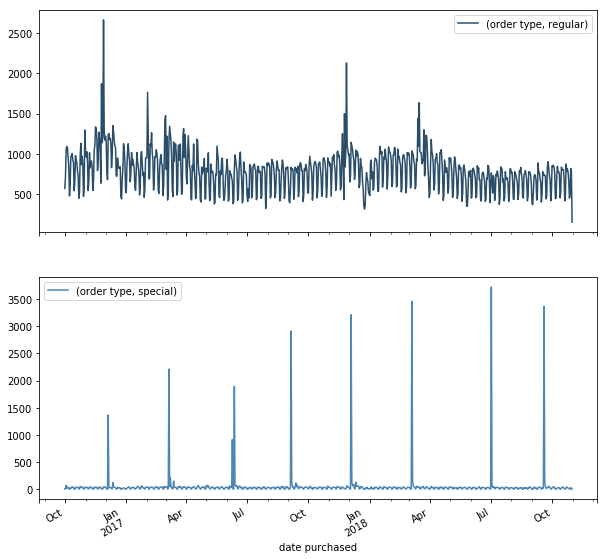

In [20]:
df1 = osh.drop_duplicates('orders id').groupby(['date purchased','order type'])[['order type']].count().unstack().fillna(0)
df1.plot(subplots = True,
        figsize = (10,10),
        color = colors[0:2])

plt.show()

In [21]:
pd.DataFrame(df1.mean()).rename(columns = {0:'avg per day'}).format_(['n0'])

Avg Per Day
           order type            
order type regular            788
           special             58

### Check osh

In [22]:
n = osh[osh.isnull().any(1)]
print('{:,.0f} nulls removed or {:,.4f}% of total lines'.format(len(n), len(n)/len(osh) * 100))
osh.dropna(inplace = True)
osh.reset_index(drop = True, inplace = True)

21 nulls removed or 0.0032% of total lines


### Check value counts of final_orders_status
No matter the status, we still printed and shipped these orders

DO NOT remove any orders based on the final OID status

In [23]:
osh['final orders status'].value_counts()

shipped               642762
return                  2846
replaced defective       206
fraud - confirmed        205
pending                  109
refunded defective        56
voided                     4
Name: final orders status, dtype: int64

### Overall sanity check

In [24]:
avg = osh.groupby('date purchased')[['orders id']].nunique().mean().values[0]
d1 = str(osh['date purchased'].min().date())
d2 = str(osh['date purchased'].max().date())
print('{:,.0f} orders per day on average from {} to {}\ndaily stats says x848'.format(avg,d1,d2))

846 orders per day on average from 2016-10-01 to 2018-10-31
daily stats says x848


### Get shipper_stats

In [25]:
d = str(osh['date shipped'].min())

stats_main = pd.read_sql(
'''
SELECT
ss_date AS date_shipped,
shippers_id,
hob_log
FROM shipper_stats
WHERE ss_date >= ' '''+ d +''' '
''', db)
col_fix(stats_main)

stats_main['date shipped'] = pd.to_datetime(stats_main['date shipped'])
stats_main['year and quarter'] = stats_main['date shipped'].map(str).str[:4] + '-Q' + stats_main['date shipped'].dt.quarter.map(str)
stats_main['day name'] = stats_main['date shipped'].dt.weekday_name
stats_main['day type'] = np.where(stats_main['day name'].isin(['Saturday','Sunday']), 'weekend','weekday')

### Avg hours of shipping per quarter per weekday type

In [298]:
stats_main.groupby([stats_main['date shipped'].dt.quarter, 'day type'])[['hob log']].mean().unstack(1)/3600

hob log          
day type       weekday   weekend
date shipped                    
1             3.513352  4.744292
2             3.342499  4.550899
3             3.256261  4.121440
4             3.468941  4.672885

### Avg hours of shipping during Q4

In [299]:
avg1 = stats_main[stats_main['year and quarter'].str.contains('-Q4')].groupby('day type')[['hob log']].mean()/3600
avg1.columns = ['avg hours of shipping']
avg1.format_(['n2'])

,Avg Hours Of Shipping
day type,
weekday,3.47
weekend,4.67


### Avg count of shippers during Q4

In [346]:
avg2 = stats_main[stats_main['year and quarter'].str.contains('-Q4')].groupby(['date shipped','day type'])[['shippers id']].count()#
avg2 = avg2.groupby(level = 1)[['shippers id']].mean().rename(columns = {'shippers id':'avg count of shippers'})
avg2.format_(['n0'])

,Avg Count Of Shippers
day type,
weekday,14
weekend,6


### Avg hours of shipping over all days

In [347]:
avg3 = stats_main[stats_main['year and quarter'].str.contains('-Q4')].groupby('date shipped')[['hob log']].mean().mean().values[0]/3600
avg3
print('avg hours of shipping per shipper over all days is {:,.2f} hours per day'.format(avg3))

avg hours of shipping per shipper over all days is 3.83 hours per day


### Get shippers data

In [28]:
sl1 = pd.read_sql(
'''
SELECT
orders_id,
shippers_id
FROM ship_log
WHERE orders_id >= '''+ str(min_oid) +'''
''', db)
col_fix(sl1)
sl1['partial id'] = 0

sl2 = pd.read_sql(
'''
SELECT
psl_parent_id AS orders_id,
psl_partial_id AS partial_id,
psl_shippers_id AS shippers_id
FROM partial_ship_log
WHERE psl_parent_id >= '''+ str(min_oid) +'''
''', db)
col_fix(sl2)

### Structure sl_main

In [29]:
sl1.drop(sl1[sl1['orders id'].isin(sl2['orders id'].tolist())].index, inplace = True)
sl1.reset_index(drop = True, inplace = True)
sl_main = pd.concat([sl1, sl2], sort = False)
sl_main['umbrella orders id'] = sl_main['orders id'].map(str) + '-' + sl_main['partial id'].map(str)

### Map shippers_id to osh

In [30]:
osh['shippers id'] = osh['umbrella orders id'].map(dict(zip(sl_main['umbrella orders id'], sl_main['shippers id'])))

In [31]:
n = osh[osh.isnull().any(1)]
print('{:,.0f} nulls removed or {:,.2f}% of total lines'.format(len(n), len(n)/len(osh) * 100))
osh.dropna(inplace = True)
osh.reset_index(drop = True, inplace = True)
osh['shippers id'] = [int(x) for x in osh['shippers id']]

77 nulls removed or 0.01% of total lines


### Avg time per shipper to ship one shipment
We are looking for the avg time per shipper to ship one shipment

This estimate includes both Non- and Resellers

Only looks at Q4

In [311]:
a = osh[osh['year and quarter purchased'].str.contains('-Q4')].groupby(['date shipped','shippers id'])[['umbrella orders id']].count().reset_index()
a.rename(columns = {'umbrella orders id':'count of shipments'}, inplace = True)
a['date shipped'] = pd.to_datetime(a['date shipped'])

b = pd.merge(a, stats_main, how = 'left', on = ['date shipped','shippers id'])

In [313]:
n = b[b.isnull().any(1)]
print('{:,.0f} null shipments removed or {:,.2f}% of total shipments'.format(n['count of shipments'].sum(), n['count of shipments'].sum()/a['count of shipments'].sum() * 100))
b.dropna(inplace = True)
b.reset_index(drop = True, inplace = True)

b.drop(b[~b['year and quarter'].str.contains('-Q4')].index, inplace = True)
b.reset_index(drop = True, inplace = True)

1,654 null shipments removed or 0.85% of total shipments


In [314]:
c = b.groupby('shippers id')[['count of shipments','hob log']].sum()
c['avg time per shipment'] = c['hob log']/c['count of shipments']

d = c['avg time per shipment'].values

### Avg time to ship one shipment

In [389]:
m = np.mean(d)
s = np.std(d)
n = len(d)
phi = stats.t.ppf(0.95, n-1)

l = m - phi * (s/np.sqrt(n))
u = m + phi * (s/np.sqrt(n))

e = pd.DataFrame([[l,m,u]], columns = ['lower','mean','upper'])

### Avg shipment count per day during Q4

In [388]:
f = osh[osh['year and quarter purchased'].str.contains('-Q4')].copy()
g = f.groupby(['date purchased','order type'])[['umbrella orders id']].count().unstack(1).fillna(0)#.rename(columns = {'umbrella orders id':'count of shipments'})
g.columns = g.columns.droplevel(0)

ls = []

for col in g.columns:
    df = g[col]
    m = df.mean()
    s = df.std()
    n = len(df)
    phi = stats.t.ppf(0.95, n-1)
    l = m - phi * (s/np.sqrt(n))
    u = m + phi * (s/np.sqrt(n))
    ls.append([col,l,m,u])
    
h = pd.DataFrame(ls, columns = ['order type','lower','mean','upper'])
h.set_index('order type', inplace = True)
st = str(f['date purchased'].min().date())
en = str(f['date purchased'].max().date())

# How many shippers per day do we need?
We're only considering data from Q4!

### Estimate: Number of shipments per day during Q4

In [390]:
h.format_(['n0'] * 3)

,Lower,Mean,Upper
order type,,,
regular,821,853,886
special,24,51,78


### Estimate: Time (in seconds) for one shipper to ship one shipment during Q4

In [391]:
e.format_(['n0'] * 3)

,Lower,Mean,Upper
0,178,232,287


### Estimate: Hours of shipping needed per day during Q4

In [392]:
i = pd.DataFrame((h[['lower','mean','upper']].values * e.values)/60/60, 
                 columns = ['lower','mean','upper'],
                 index = ['regular','special'])
i.format_(['n0'] * 3)

,Lower,Mean,Upper
regular,40,55,71
special,1,3,6


In [393]:
print('actual avg hours a shipper ships per day is {:,.2f}'.format(avg3))

actual avg hours a shipper ships per day is 3.83


In [363]:
val = avg3
val = 5 # if you could get the shippers to ship for this long you'd have the following

### Estimate: Number of shippers needed per day during Q4

In [395]:
print('if an avg shipper ships for {:,.2f} hours per day'.format(val))
(i/val).format_(['n0'] * 3)

if an avg shipper ships for 5.00 hours per day


,Lower,Mean,Upper
regular,8,11,14
special,0,1,1


### Estimate: Number of shippers needed per week during Q4

In [396]:
print('each shipping {:,.2f} hours per day'.format(val))
(i/val * 7).format_(['n0'] * 3)

each shipping 5.00 hours per day


,Lower,Mean,Upper
regular,57,77,99
special,2,5,9


### Actual: Count of shippers per day type

In [362]:
print('actual avg count of shippers per day type')
avg2.format_(['n0'])

actual avg count of shippers per day type


,Avg Count Of Shippers
day type,
weekday,14
weekend,6


In [357]:
# we currently have 14 shippers during the week
# and 6 shippers on the weekends

total = 14*5 + 6*2



82

### Get on-time stats
Give some context to actual and estimates above

In [383]:
more_stats = pd.read_sql(
'''
SELECT
DATE(ss_date) AS date,
SUM(orders_shipped_on_time) AS on_time,
SUM(orders_not_shipped_on_time) AS not_on_time
FROM shipping_stats
WHERE ss_date >= ' '''+ date_start +''' '
GROUP BY ss_date
''', db)

col_fix(more_stats)

more_stats['date'] = pd.to_datetime(more_stats['date'])
more_stats['year and quarter'] = more_stats['date'].map(str).str[:4] + '-Q' + more_stats['date'].dt.quarter.map(str)
more_stats['total'] = more_stats[['on time','not on time']].sum(1)

more_stats2 = more_stats[more_stats['year and quarter'].str.contains('-Q4')]
more_stats2 = more_stats2.loc[(more_stats2 > 0).all(1)]

st = str(more_stats2['date'].min().date())
en = str(more_stats2['date'].min().date())

print('data is from {} to {} and only includes Q4'.format(st,en))
more_stats2[['on time','not on time']].div(more_stats2['total'], axis = 0).dropna().mean()

data is from 2017-10-01 to 2017-10-01 and only includes Q4


on time        0.837202
not on time    0.162798
dtype: float64